## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
from random import shuffle
from scipy.stats import kurtosis
from math import pi, sqrt
from sklearn.metrics import confusion_matrix
from tabulate import tabulate
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

## Question 1

#### Function Definitions

In [2]:
def Prior(X, Y):
    
# Calculates the prior for each class
# Inputs:
#     X --> Datapoints 
#     Y --> Class labels of X
# Returns:
#     P --> Prior for each class
 
    classes = np.unique(Y)
    P = []
    for c in classes:
        P.append(len(np.argwhere(Y==c))/len(Y))
    return np.array(P)



In [3]:
def MultivariateNormal(X, mu, cov):
    
# Calculates pdf value for a given value, multivaraite normal distribution parameters
# Inputs:
#     X ----> Datapoints 
#     mu ---> Mean of the multivaraite normal distribution 
#     cov --> Covaraince matrix of the multivaraite normal distribution
# Returns:
#     pdf --> pdf value for all the datapoints

    try:
        k = X.shape[1]
    except:
        X = X.reshape(1,-1)
        k = X.shape[1]        
    sf = sqrt(np.linalg.det(cov)*(2*pi)**k)
    exp_val = np.array(np.sum(np.multiply(np.matmul((X - mu), np.linalg.inv(cov)), (X - mu)), axis = 1), dtype=np.longdouble)
   
    pdf = np.exp(-exp_val/2)/sf
    return pdf

In [4]:
def Classifier(X, classes, mean_MLE, cov_MLE, prior, Loss_matrix, classifier_type):

# Classifies the given datapoints 
# Inputs:
#     X ---------------> Datapoints 
#     classes ---------> Possible classes to which X can belong 
#     mean_MLE --------> MLE estimates of the mean of each class
#     cov_MLE ---------> MLE estimates of the covaraince matrix of each class
#     Loss_matrix -----> Loss matrix 
#     classifier_type -> Type of classifer to be used 
# Returns:
#     Y_pred ----------> Predicted classes     
    
    n_classes = len(classes)
    N = X.shape[0]
    d = X.shape[1]
       
    if classifier_type == 'NaiveBayes_Cov_I':
        arg = [np.identity(d)]*n_classes
    elif  classifier_type == 'NaiveBayes_Same_Cov':
        cov_NB = [np.diag(np.diag(cov)) for cov in cov_MLE]
        arg = [np.sum(np.array([p*cov for p,cov in zip(prior,cov_NB)]), axis = 0)]*n_classes
    elif classifier_type == 'NaiveBayes_Diff_Cov':
        arg = [np.diag(np.diag(cov)) for cov in cov_MLE]
    elif classifier_type == 'Bayes_Same_Cov':
        arg = [np.sum(np.array([p*cov for p,cov in zip(prior,cov_MLE)]), axis = 0)]*n_classes
    elif classifier_type == 'Bayes_Diff_Cov':
        arg = cov_MLE
       
    posterior = np.zeros((N, n_classes))    
    for c in classes:
        q = MultivariateNormal(X, mean_MLE[c], arg[c])*prior[c]
        
        posterior[:,c] = q

    g = np.zeros((N, n_classes))
    for i in classes:
        g[:,i] = np.dot(posterior, Loss_matrix[i,:])
    
    Y_pred = np.argmin(g, axis=1)
    
    return Y_pred
    

In [5]:
def decision_region(x_train, y_train, classes, mean_MLE, cov_MLE, prior, Loss_matrix, classifier_type):

# Plots the decision region
# Inputs:
#     x_train ---------> Training Datapoints
#     y_train ---------> Class labels for x_train
#     classes ---------> Possible classes to which X can belong 
#     mean_MLE --------> MLE estimates of the mean of each class
#     cov_MLE ---------> MLE estimates of the covaraince matrix of each class
#     prior -----------> prior probability of all the classes
#     Loss_matrix -----> Loss matrix 
#     classifier_type -> Type of classifer to be used 
# Returns:
#     None  

    x_min, x_max = x_train[:, 0].min() - 1, x_train[:, 0].max() + 1
    y_min, y_max = x_train[:, 1].min() - 1, x_train[:, 1].max() + 1
    h = .2  
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    x = np.c_[xx.ravel(), yy.ravel()]
    y_pred = Classifier(x, classes, mean_MLE, cov_MLE, prior, Loss_matrix, classifier_type)
    
    y_pred = np.array(y_pred).reshape(xx.shape)
    
    classes = np.unique(y_train).astype(str)
    plt.style.use('classic')
    plt.pcolormesh(xx, yy, y_pred, cmap=plt.cm.Paired)
    scatter = plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, edgecolors='k', cmap=plt.cm.Paired)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("Decision Boundary: " + classifier_type)
    plt.xlabel('x_1')
    plt.ylabel('x_2')
    plt.legend(handles=scatter.legend_elements()[0], labels=list(map(lambda x: 'Class {}'.format(x), classes)))
    plt.show()

In [6]:
def accuracy(Y_true, Y_pred):
    
# Returns the accuracy of predicted classes
# Inputs:
#     Y_true -----> True class labels
#     Y_pred -----> Predicted class labels
# Returns:
#     tp/N -------> Accuracy of predicted class labels 

    tp = len(np.argwhere(Y_true==Y_pred))
    N  = Y_true.shape[0]
    return tp/N

In [7]:
def confusion_matrix_plot(Y_true, Y_pred, return_mat = False):
    
# Plots and returns the confusion matrix (if asked) given the predictions and the the true labels
# Inputs:
#     Y_true ------> True class labels
#     Y_pred ------> Predicted class labels
#     return_mat --> Flag to specify if confusion matrix should be returned 
# Returns:
#     conf_mat ------> Confusion Matrix (if return_mat=True)

    n_classes = len(np.unique(Y_true))
    conf_mat = np.zeros((n_classes,n_classes))
    for i in range(n_classes):
        for j in range(n_classes):
            true_i = np.argwhere(Y_true==i).ravel()
            pred_j = np.argwhere(Y_pred==j).ravel()
            conf_mat[i][j] = int(len(np.intersect1d(true_i, pred_j)))
    
    conf_percentage = np.around((conf_mat*100/np.sum(conf_mat)), decimals=2)
    conf_percentage = np.array(list(map(lambda x: str(x) +'%', conf_percentage.ravel()))).reshape(n_classes,n_classes)
    
    h = np.around(list(np.diag(conf_mat)*100/np.sum(conf_mat, axis = 0)) + [100*np.sum(np.diag(conf_mat))/np.sum(conf_mat)], decimals=1)
    h_neg = np.around(list(100 - h), decimals=1)
    v = np.around(np.diag(conf_mat)*100/np.sum(conf_mat, axis = 1), decimals=1)
    v_neg = np.around(100 - v, decimals=1)

    v_new = np.array(list(map(lambda x: str(x) +'%', v)))
    h_new = np.array(list(map(lambda x: str(x) +'%', h)))
    
    v_neg_new = np.array(list(map(lambda x: str(x) +'%', v_neg)))
    h_neg_new = np.array(list(map(lambda x: str(x) +'%', h_neg)))
    
    
    label_up = np.vstack((np.vstack((conf_mat.astype(str).T,v_new)).T, h_new))
    label_down = np.vstack((np.vstack((conf_percentage.astype(str).T,v_neg_new)).T, h_neg_new))
    label_all = np.array(list(map(lambda x, y: str(x) + '\n' + str(y), list(label_up.ravel()), list(label_down.ravel())))).reshape(n_classes+1, n_classes+1)
    
    dummy = (np.min(conf_mat)+np.max(conf_mat))/2
    labels = ['Class {}'.format(c) for c in list(np.unique(Y).astype(str))] + ['Sum']
    conf_df = pd.DataFrame(np.vstack((np.vstack((conf_mat,np.array([dummy]*3))).T,[dummy]*4)), index = labels, columns = labels)
    
    sns.set(rc={'figure.figsize':(8,8)})
    ax = sns.heatmap(conf_df, annot=label_all, fmt = '', annot_kws={"size": 15}, cbar=False, cmap='summer', linecolor='k', linewidths=.1, square= True) 
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    ax.set_facecolor("grey")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()
            
    if return_mat == True:
        return conf_mat              

#### Loading dataset 1

In [8]:
data = pd.read_csv('Dataset_1_Team_7.csv')
X = data.drop('Class_label', axis = 1).values
Y = data['Class_label'].values

N = X.shape[0]
train_N = int(0.8*N)
order = list(range(N))
np.random.shuffle(order)

X_train = X[order[:train_N],:]
Y_train = Y[order[:train_N]]

X_test = X[order[train_N:],:]
Y_test = Y[order[train_N:]]

#### Visualisation and analysis of the dataset

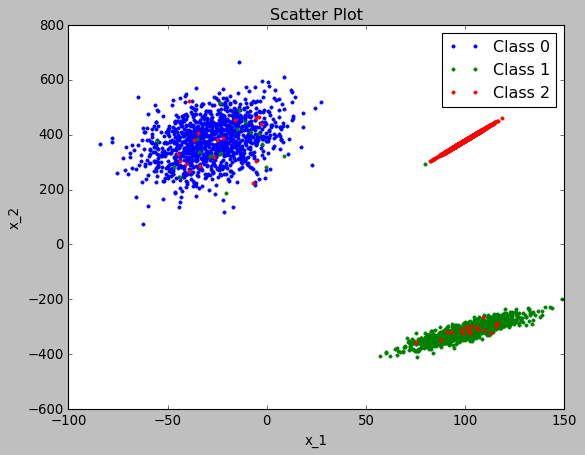

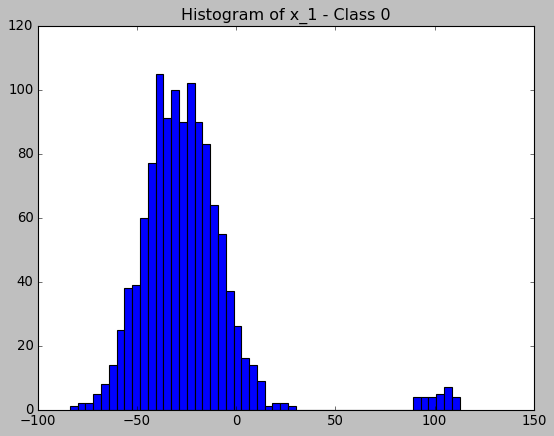

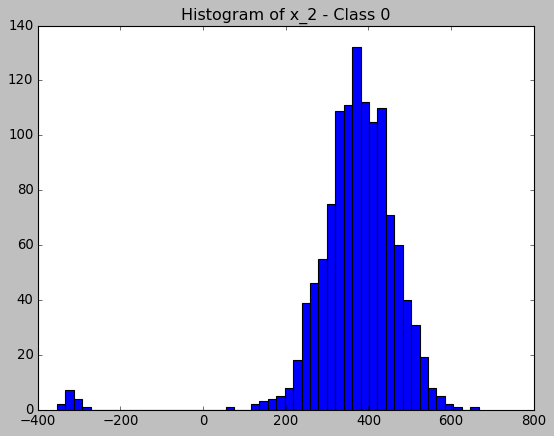

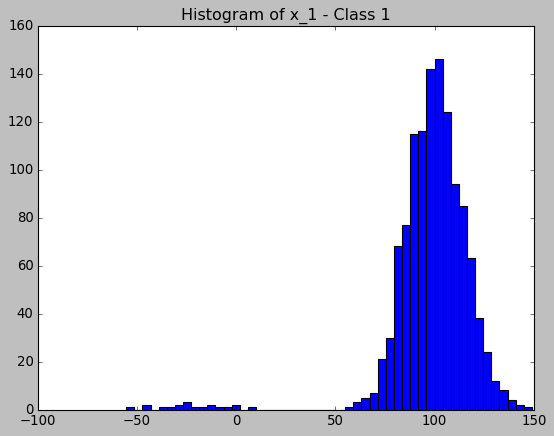

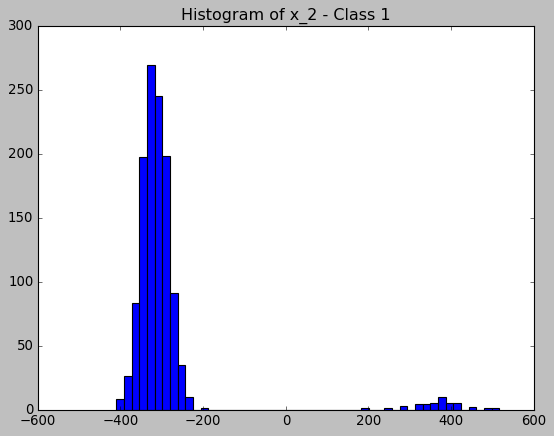

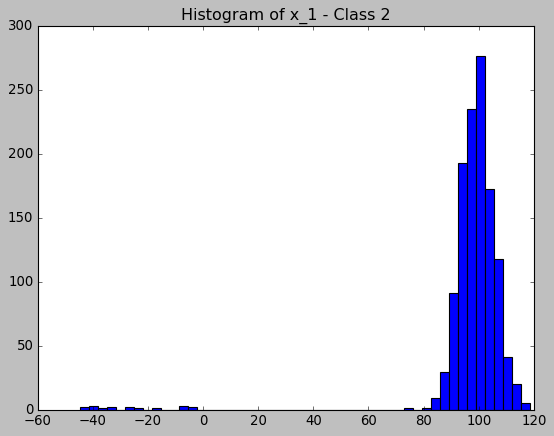

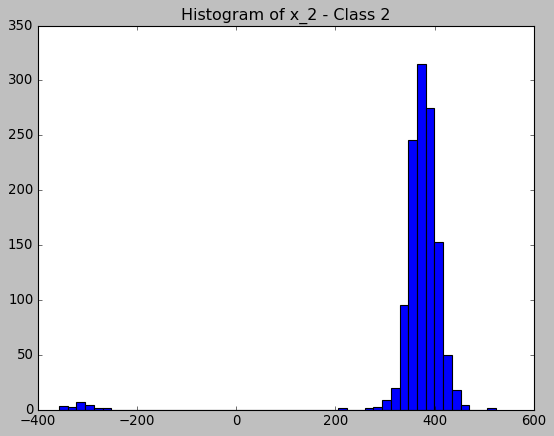

In [9]:
# Scatter plots 
plt.style.use('classic')

classes = np.unique(Y_train)
for c in classes:
    x_c = X_train[np.argwhere(Y_train==c).ravel(),:]
    plt.plot(x_c[:,0], x_c[:,1],'.')
    
plt.title('Scatter Plot')
plt.legend(['Class 0','Class 1','Class 2'])
plt.xlabel('x_1')
plt.ylabel('x_2')
plt.show()    

# Histogarms 
for c in classes:
    x_c = X_train[np.argwhere(Y_train==c).ravel(),:]
    plt.hist(x_c[:,0], bins = 50)
    plt.title('Histogram of x_1 - Class {0}'.format(c))
    plt.show()
    plt.hist(x_c[:,1], bins = 50)
    plt.title('Histogram of x_2 - Class {0}'.format(c))
    plt.show()    
    
#     print('\nKurtosis of x_1 - Class {0} = {1}'.format(c,kurtosis(x_c[:,0])))
#     print('Kurtosis of x_2 - Class {0} = {1}'.format(c,kurtosis(x_c[:,1])))

#### Naive Bayes and Bayes Classifier

In [10]:
Loss_matrix = np.array([[0, 2, 1], [2, 0, 3], [1, 3, 0]])

# Estimating prior probability
prior = Prior(X_train, Y_train)

In [11]:
# Estimating class conditional 
classes = np.unique(Y_train)
n_classes = len(classes)

mean_MLE = []
cov_MLE  = []

for c in classes:
    x_c = X_train[np.argwhere(Y_train==c).ravel(),:]
    mean_MLE.append(np.mean(x_c, axis = 0))
    cov_MLE.append(np.cov(x_c.T)*N/(N-1))

#### Getting predictions for all the models 

In [12]:
models = ['NaiveBayes_Cov_I', 'NaiveBayes_Same_Cov','NaiveBayes_Diff_Cov', 'Bayes_Same_Cov', 'Bayes_Diff_Cov']

In [13]:
Y_pred_train = []
Y_pred_test = []
for m in models:
    Y_pred_train.append(Classifier(X_train, classes, mean_MLE, cov_MLE, prior, Loss_matrix, m))
    Y_pred_test.append(Classifier(X_test, classes, mean_MLE, cov_MLE, prior, Loss_matrix, m))

#### (i) Accuracy 

In [14]:
table = []
headers = ["Model number", "Train Accuracy", "Test Accuracy"]
 
    
for i in range(len(models)):
    table.append([i+1, accuracy(Y_train, Y_pred_train[i]), accuracy(Y_test, Y_pred_test[i])])

print(tabulate(table, headers, tablefmt = 'fancy_grid'))

╒════════════════╤══════════════════╤═════════════════╕
│   Model number │   Train Accuracy │   Test Accuracy │
╞════════════════╪══════════════════╪═════════════════╡
│              1 │         0.794444 │        0.79     │
├────────────────┼──────────────────┼─────────────────┤
│              2 │         0.970833 │        0.974444 │
├────────────────┼──────────────────┼─────────────────┤
│              3 │         0.970833 │        0.974444 │
├────────────────┼──────────────────┼─────────────────┤
│              4 │         0.970833 │        0.974444 │
├────────────────┼──────────────────┼─────────────────┤
│              5 │         0.970833 │        0.974444 │
╘════════════════╧══════════════════╧═════════════════╛


###### Models 2 to 5 perform equally well. Hence all 4 models are equally good (based on accuracy). Hence, models 2,3,4,5 have been selected for the consecutive parts 

#### (ii) Confusion matrix:


Model 2 - Training data:


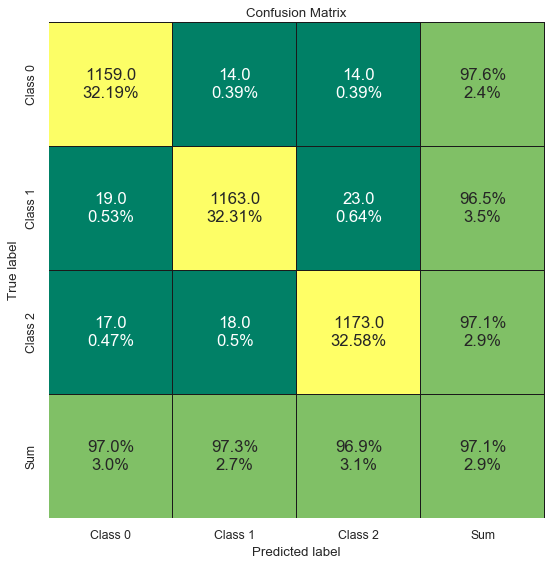


Model 2 - Test data:


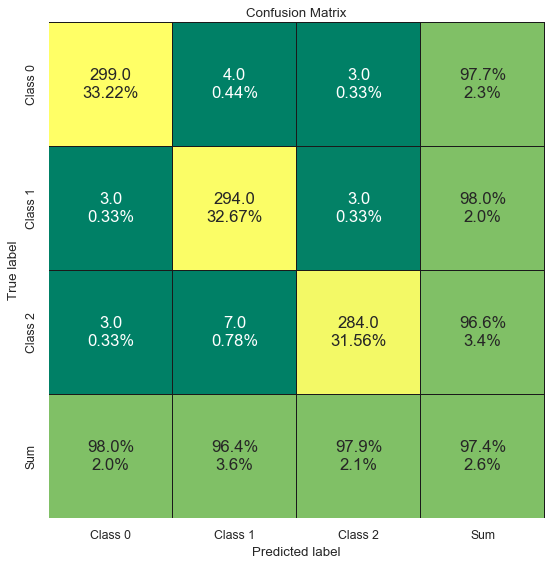


Model 3 - Training data:


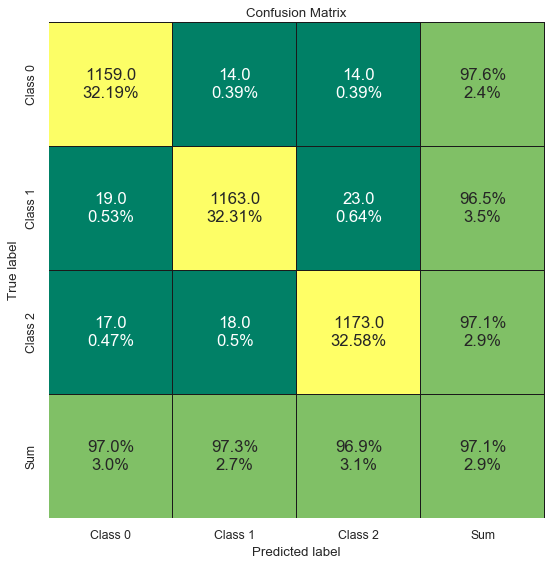


Model 3 - Test data:


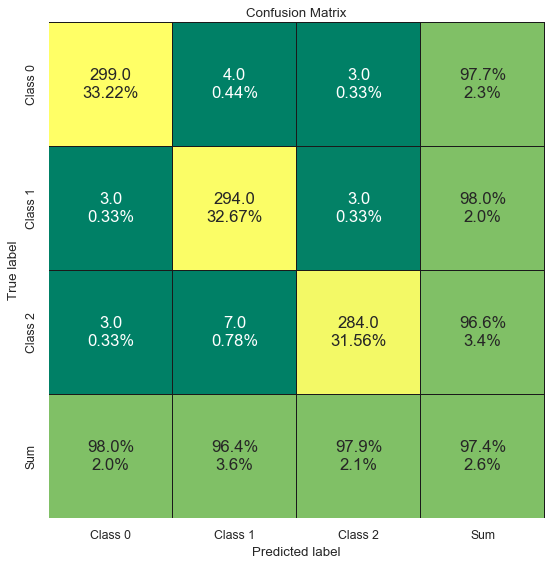


Model 4 - Training data:


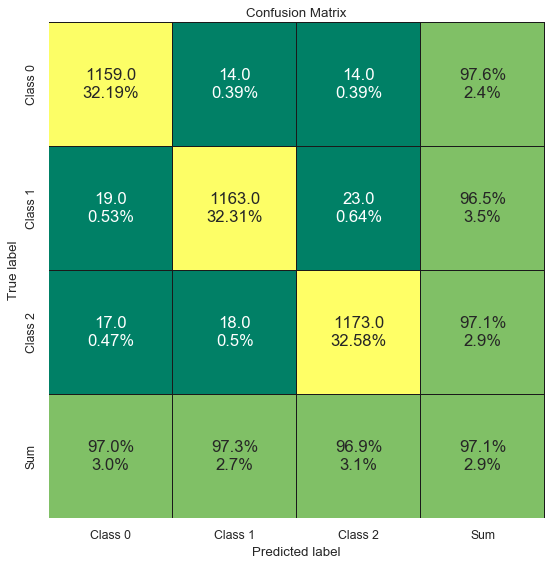


Model 4 - Test data:


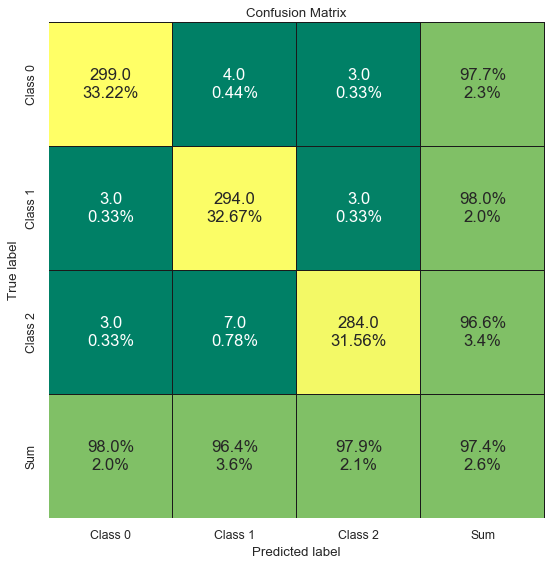


Model 5 - Training data:


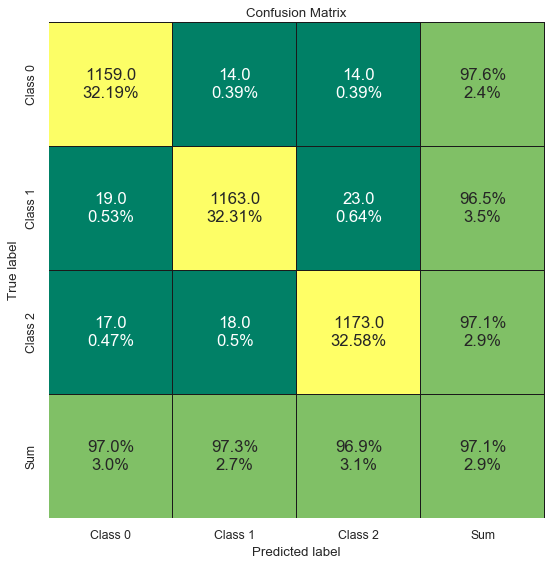


Model 5 - Test data:


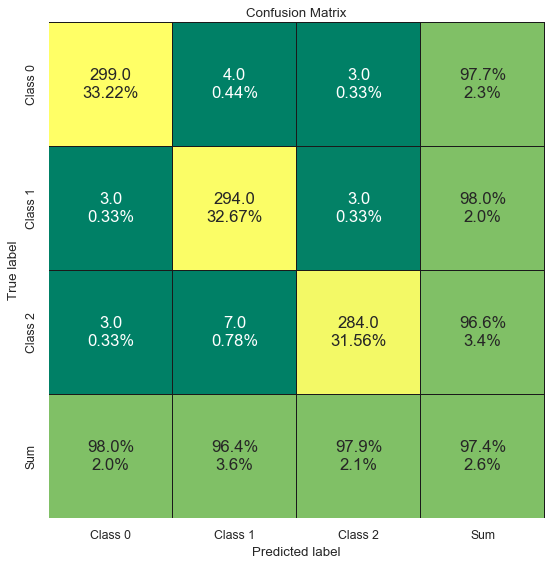

In [15]:
for i in range(len(models[1:])):
    print('\nModel {} - Training data:'.format(i+2))
    confusion_matrix_plot(Y_train, Y_pred_train[i+1])
    print('\nModel {} - Test data:'.format(i+2))
    confusion_matrix_plot(Y_test, Y_pred_test[i+1])


#### (iii) Decision boundary:

Model 2:


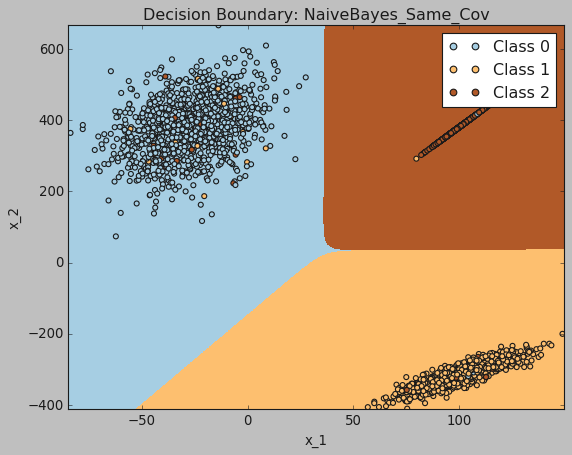

Model 3:


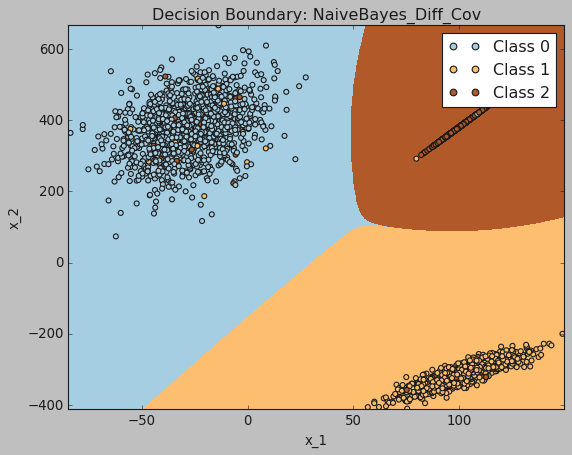

Model 4:


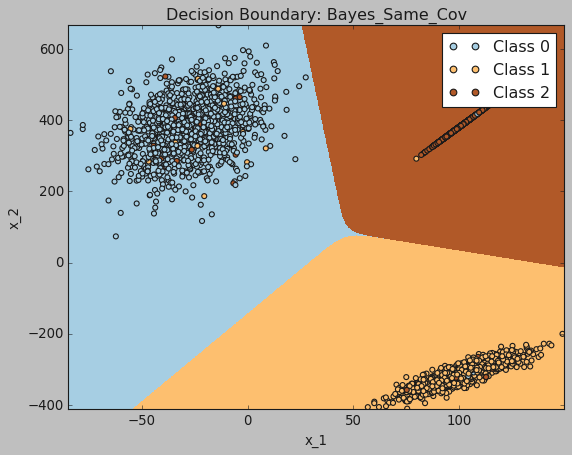

Model 5:


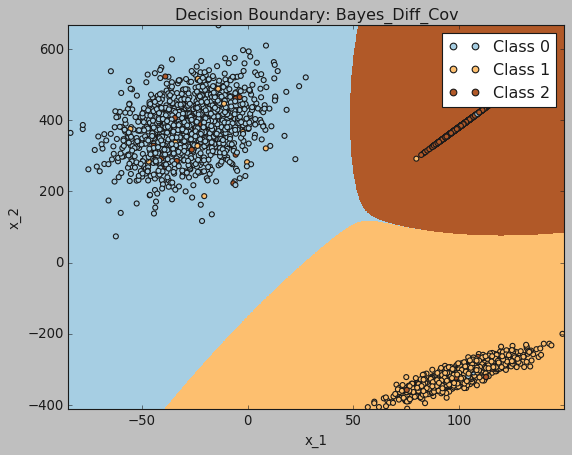

In [16]:
for i in range(len(models[1:])):
    print('Model {}:'.format(i+2))    
    decision_region(X_train, Y_train, classes, mean_MLE, cov_MLE, prior, Loss_matrix, models[i+1])


#### (iv) Contour curves and eigenvectors:

Model 2:
NaiveBayes_Same_Cov


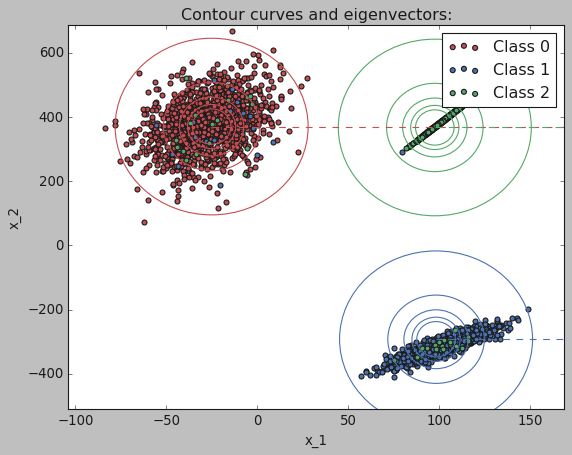

Model 3:
NaiveBayes_Diff_Cov


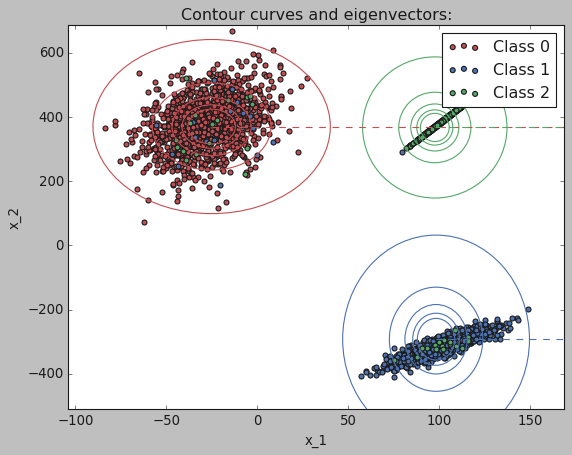

Model 4:
Bayes_Same_Cov


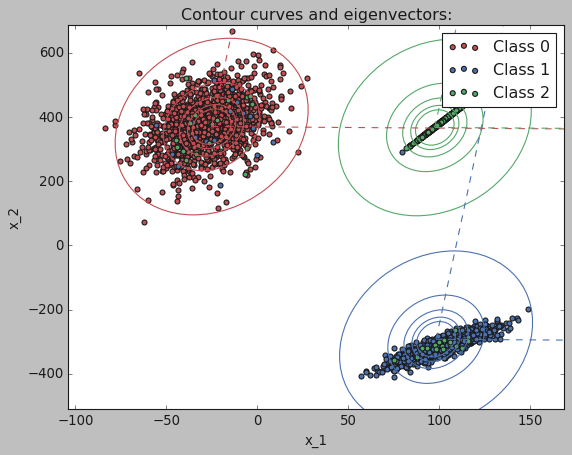

Model 5:
Bayes_Diff_Cov


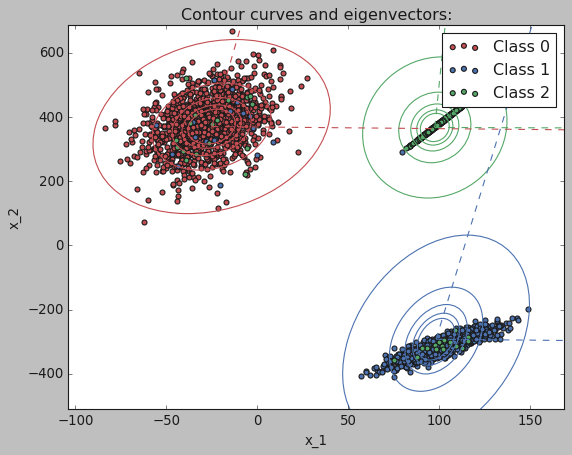

In [17]:
for i in range(len(models[1:])):
    
    print('Model {}:'.format(i+2))
    print(models[i+1])
    if models[i+1] == 'NaiveBayes_Cov_I':
        cov_mat = [np.identity(d)]*n_classes
    elif  models[i+1] == 'NaiveBayes_Same_Cov':
        cov_NB = [np.diag(np.diag(cov)) for cov in cov_MLE]
        cov_mat = [np.sum(np.array([p*cov for p,cov in zip(prior,cov_NB)]), axis = 0)]*n_classes
    elif models[i+1] == 'NaiveBayes_Diff_Cov':
        cov_mat = [np.diag(np.diag(cov)) for cov in cov_MLE]
    elif models[i+1] == 'Bayes_Same_Cov':
        cov_mat = [np.sum(np.array([p*cov for p,cov in zip(prior,cov_MLE)]), axis = 0)]*n_classes
    elif models[i+1] == 'Bayes_Diff_Cov':
        cov_mat = cov_MLE

    colors = ['r', 'b', 'g']
    for c in classes:
        x_c = X_train[np.argwhere(Y_train==c).ravel(),:]    
        eig_val, eig_vec= np.linalg.eig(cov_mat[c]) 
        lambdaVal = np.sqrt(eig_val)

        # Contour curves
        ax = plt.subplot(111)       
        for i in range(1, 6):
            ellipse = Ellipse(xy=(np.mean(x_c[:,0]), np.mean(x_c[:,1])), width=lambdaVal[0]*5/i, height=lambdaVal[1]*5/i, angle=np.rad2deg(np.arccos(eig_vec[0, 0])))
            ellipse.set_facecolor('none')
            ellipse.set_edgecolor(colors[c])
            ax.add_artist(ellipse)


        # Eigenvectors 
        m1 = np.tan(np.arccos(eig_vec[0, 0]))
        m2 = -1/m1
        x = np.linspace(np.mean(x_c[:,0]), np.max(X_train[:,0])+20, 100)
        y1 = m1*x + np.mean(x_c[:,1]) - m1*np.mean(x_c[:,0])
        y2 = m2*x + np.mean(x_c[:,1]) - m2*np.mean(x_c[:,0])
        plt.plot(x,y1,'--'+colors[c])
        plt.plot(x,y2,'--'+colors[c])

        plt.xlim([np.min(X_train[:,0])-20, np.max(X_train[:,0])+20])    
        plt.ylim([np.min(X_train[:,1])-100, np.max(X_train[:,1])+20])


        # Scatter plot
        ax.scatter(x_c[:,0], x_c[:,1], c = colors[c], label = 'Class '+str(c))
    ax.legend()
    plt.title('Contour curves and eigenvectors:')  
    plt.xlabel('x_1')
    plt.ylabel('x_2')
    plt.show()


#### Loading dataset 2

In [18]:
data = pd.read_csv('Dataset_2_Team_7.csv')
X = data.drop('Class_label', axis = 1).values
Y = data['Class_label'].values

N = X.shape[0]
train_N = int(0.8*N)
order = list(range(N))
np.random.shuffle(order)

X_train = X[order[:train_N],:]
Y_train = Y[order[:train_N]]

X_test = X[order[train_N:],:]
Y_test = Y[order[train_N:]]

#### Visualisation and analysis of the dataset

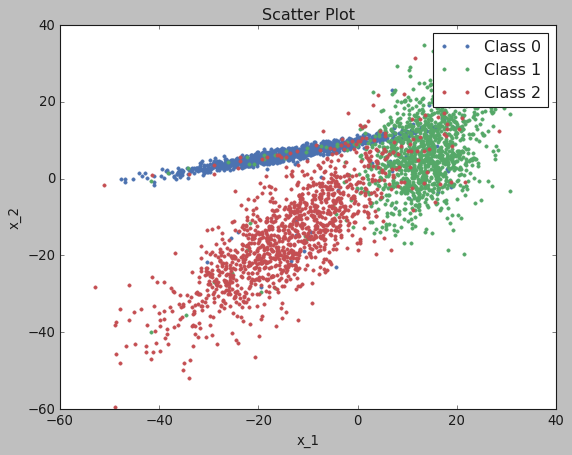

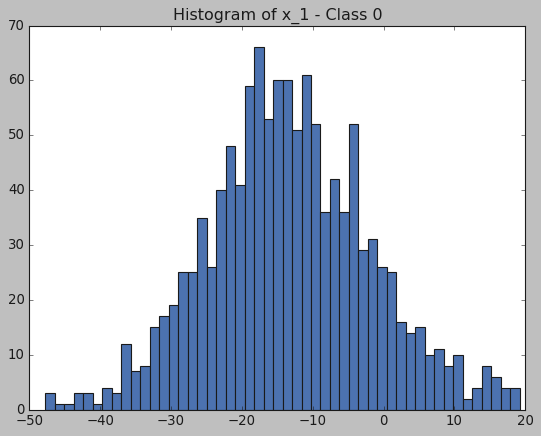

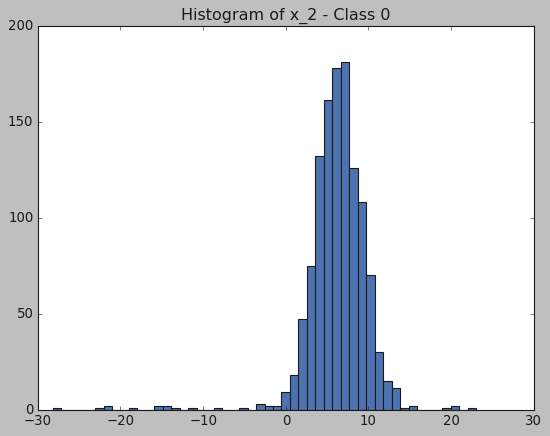

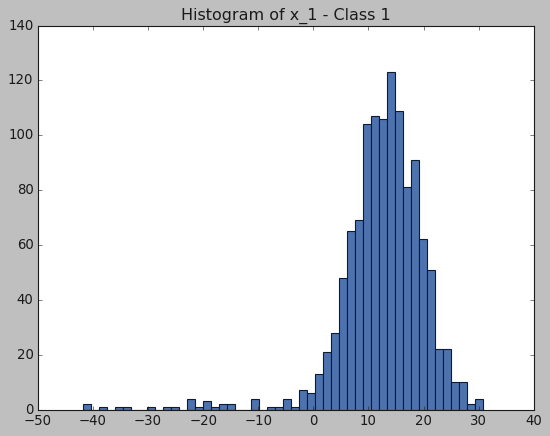

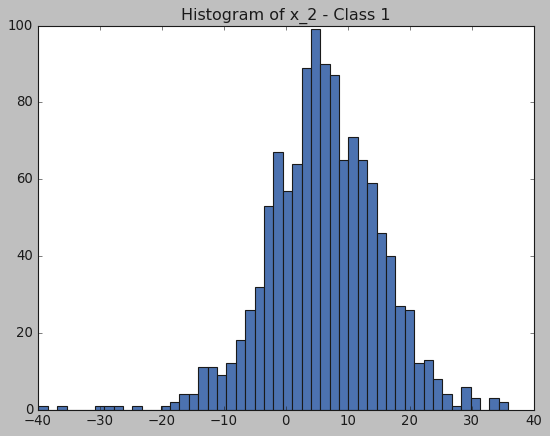

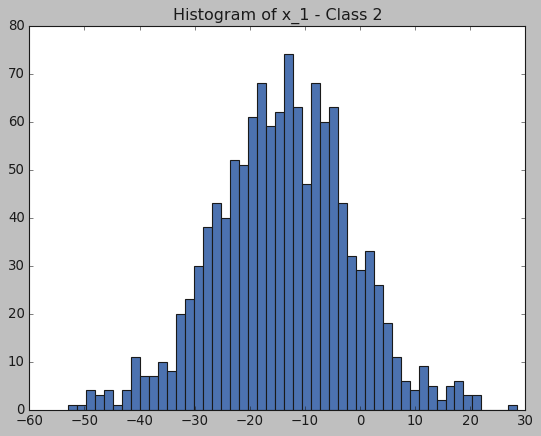

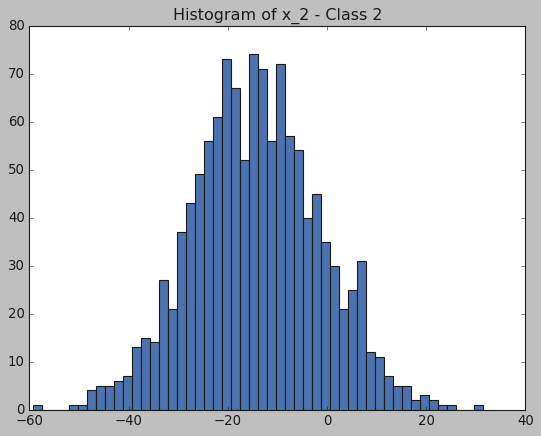

In [19]:
# Scatter plots 

plt.style.use('classic')

classes = np.unique(Y_train)
for c in classes:
    x_c = X_train[np.argwhere(Y_train==c).ravel(),:]
    plt.plot(x_c[:,0], x_c[:,1],'.')
    
plt.title('Scatter Plot')
plt.legend(['Class 0','Class 1','Class 2'])
plt.xlabel('x_1')
plt.ylabel('x_2')
plt.show()    

# Histogarms 
for c in classes:
    x_c = X_train[np.argwhere(Y_train==c).ravel(),:]
    plt.hist(x_c[:,0], bins = 50)
    plt.title('Histogram of x_1 - Class {0}'.format(c))
    plt.show()
    plt.hist(x_c[:,1], bins = 50)
    plt.title('Histogram of x_2 - Class {0}'.format(c))
    plt.show()    
    
#     print('\nKurtosis of x_1 - Class {0} = {1}'.format(c,kurtosis(x_c[:,0])))
#     print('Kurtosis of x_2 - Class {0} = {1}'.format(c,kurtosis(x_c[:,1])))

#### Naive Bayes and Bayes Classifier

In [20]:
Loss_matrix = np.array([[0, 2, 1], [2, 0, 3], [1, 3, 0]])

# Estimating prior probability
prior = Prior(X_train, Y_train)

In [21]:
# Estimating class conditional 
classes = np.unique(Y_train)
n_classes = len(classes)

mean_MLE = []
cov_MLE  = []

for c in classes:
    x_c = X_train[np.argwhere(Y_train==c).ravel(),:]
    mean_MLE.append(np.mean(x_c, axis = 0))
    cov_MLE.append(np.cov(x_c.T)*N/(N-1))

#### Getting predictions for all the models 

In [22]:
models = ['NaiveBayes_Cov_I', 'NaiveBayes_Same_Cov','NaiveBayes_Diff_Cov', 'Bayes_Same_Cov', 'Bayes_Diff_Cov']

In [23]:
Y_pred_train = []
Y_pred_test = []
for m in models:
    Y_pred_train.append(Classifier(X_train, classes, mean_MLE, cov_MLE, prior, Loss_matrix, m))
    Y_pred_test.append(Classifier(X_test, classes, mean_MLE, cov_MLE, prior, Loss_matrix, m))

#### (i) Accuracy 

In [24]:
table = []
headers = ["Model number", "Train Accuracy", "Test Accuracy"]
 
    
for i in range(len(models)):
    table.append([i+1, accuracy(Y_train, Y_pred_train[i]), accuracy(Y_test, Y_pred_test[i])])

print(tabulate(table, headers, tablefmt = 'fancy_grid'))

╒════════════════╤══════════════════╤═════════════════╕
│   Model number │   Train Accuracy │   Test Accuracy │
╞════════════════╪══════════════════╪═════════════════╡
│              1 │         0.858333 │        0.867778 │
├────────────────┼──────────────────┼─────────────────┤
│              2 │         0.853333 │        0.862222 │
├────────────────┼──────────────────┼─────────────────┤
│              3 │         0.882222 │        0.891111 │
├────────────────┼──────────────────┼─────────────────┤
│              4 │         0.874722 │        0.882222 │
├────────────────┼──────────────────┼─────────────────┤
│              5 │         0.903611 │        0.908889 │
╘════════════════╧══════════════════╧═════════════════╛


###### Model 5 is the best in terms of accuracy (both test and train). Hence the 5th model has been selected for the consecutive parts 

#### (ii) Confusion matrix:


Model 5 - Training data:


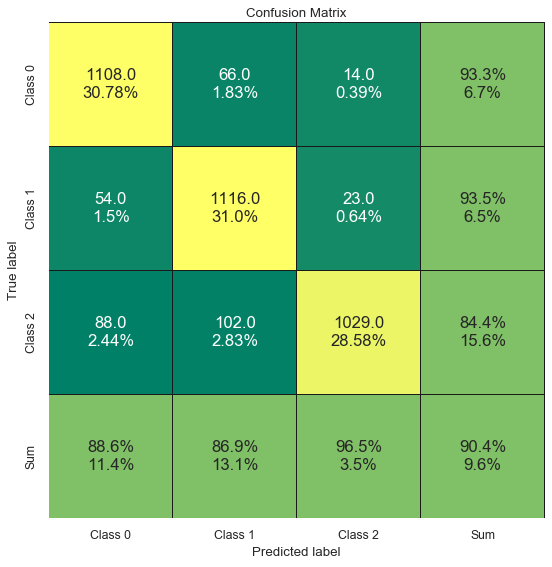


Model 5 - Test data:


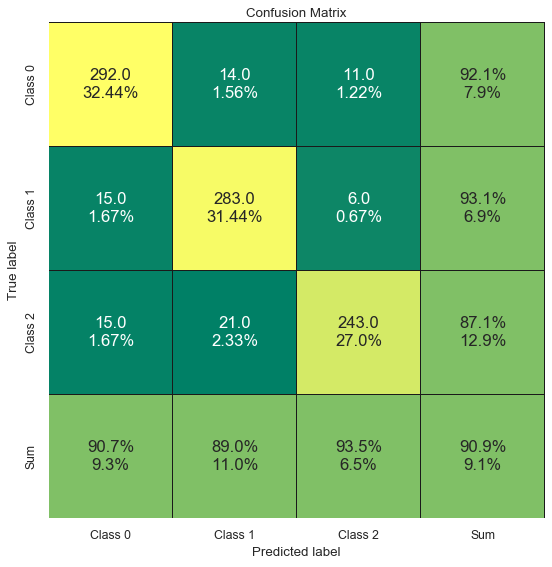

In [25]:
print('\nModel {} - Training data:'.format(5))
confusion_matrix_plot(Y_train, Y_pred_train[-1])
print('\nModel {} - Test data:'.format(5))
confusion_matrix_plot(Y_test, Y_pred_test[-1])


#### (iii) Decision boundary:

Model 5:


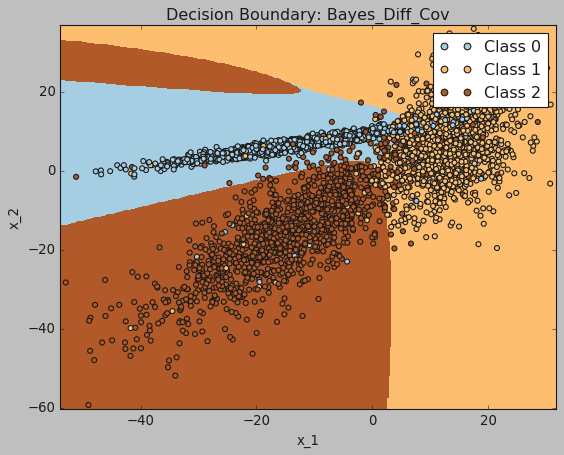

In [26]:
print('Model {}:'.format(5))    
decision_region(X_train, Y_train, classes, mean_MLE, cov_MLE, prior, Loss_matrix, models[-1])


#### (iv) Contour curves and eigenvectors:

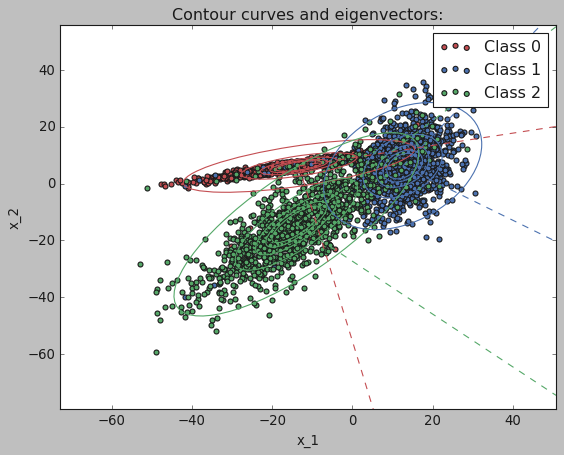

In [27]:
colors = ['r', 'b', 'g']
for c in classes:
    x_c = X_train[np.argwhere(Y_train==c).ravel(),:]    
    eig_val, eig_vec= np.linalg.eig(cov_MLE[c]) 
    lambdaVal = np.sqrt(eig_val)

    # Contour curves
    ax = plt.subplot(111)       
    for i in range(1, 6):
        ellipse = Ellipse(xy=(np.mean(x_c[:,0]), np.mean(x_c[:,1])), width=lambdaVal[0]*5/i, height=lambdaVal[1]*5/i, angle=np.rad2deg(np.arccos(eig_vec[0, 0])))
        ellipse.set_facecolor('none')
        ellipse.set_edgecolor(colors[c])
        ax.add_artist(ellipse)

        
    # Eigenvectors 
    m1 = np.tan(np.arccos(eig_vec[0, 0]))
    m2 = -1/m1
    x = np.linspace(np.mean(x_c[:,0]), np.max(X_train[:,0])+20, 100)
    y1 = m1*x + np.mean(x_c[:,1]) - m1*np.mean(x_c[:,0])
    y2 = m2*x + np.mean(x_c[:,1]) - m2*np.mean(x_c[:,0])
    plt.plot(x,y1,'--'+colors[c])
    plt.plot(x,y2,'--'+colors[c])
    
    plt.xlim([np.min(X_train[:,0])-20, np.max(X_train[:,0])+20])    
    plt.ylim([np.min(X_train[:,1])-20, np.max(X_train[:,1])+20])

    # Scatter plot
    ax.scatter(x_c[:,0], x_c[:,1], c = colors[c], label = 'Class '+str(c))
ax.legend()
plt.title('Contour curves and eigenvectors:')    
plt.xlabel('x_1')
plt.ylabel('x_2')
plt.show()
